[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/marginalization.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [ ]:
# !pip install pzflow

-------------------
## Marginalization during posterior calculation

This example notebook demonstrates how to marginalize over missing variables during posterior calculation.
We will use the Flow trained in the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb).

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
from pzflow.examples import get_example_flow

First let's load the pre-trained flow, and use it to generate some samples:

In [2]:
flow = get_example_flow()
samples = flow.sample(2, seed=123)

In [3]:
samples

,redshift,u,g,r,i,z,y
0,0.499952,27.598946,26.748329,25.781645,25.457640,25.278704,25.096481
1,1.180598,26.652370,26.282919,25.781929,25.357738,24.700449,24.377434


Remember that we can calculate posteriors for the data in samples. For example, let's plot redshift posteriors:

In [4]:
grid = np.linspace(0.25, 1.45, 100)
pdfs = flow.posterior(samples, column="redshift", grid=grid)

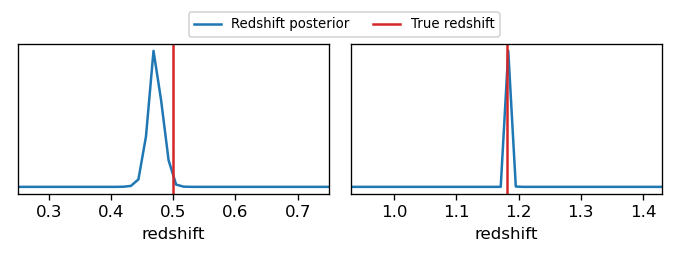

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(5.5, 2), dpi=120, constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(grid, pdfs[i], label="Redshift posterior")
    
    ztrue = samples["redshift"][i]
    ax.axvline(ztrue, c="C3", label="True redshift")
    ax.set(
        xlabel="redshift", 
        xlim=(ztrue - 0.25, ztrue + 0.25), 
        yticks=[]
    )
    
axes[0].legend(
    bbox_to_anchor=(0.55, 1.05, 1, 0.2), 
    loc="lower left",
    mode="expand", 
    borderaxespad=0, 
    ncol=2,
    fontsize=8,
)

plt.show()

But what if we have missing values? E.g. let's imagine that galaxy 1 wasn't observed in the u band, while galaxy 2 wasn't observed in the u or y bands. We will mark these non-observations with the value 99:

In [6]:
# make a new copy of the samples
samples2 = samples.copy()
# make the non-observations
samples2.iloc[0, 1] = 99
samples2.iloc[1, 1] = 99
samples2.iloc[1, -1] = 99
# print the new samples
samples2

,redshift,u,g,r,i,z,y
0,0.499952,99.0,26.748329,25.781645,25.457640,25.278704,25.096481
1,1.180598,99.0,26.282919,25.781929,25.357738,24.700449,99.000000


Now if we want to calculate posteriors, we can't simply call `flow.posterior()` as before because the flow will think that 99 is the actual value for those bands, rather than just a flag for a missing value. What we can do, however, is pass `marg_rules`, which is a dictionary of rules that tells the Flow how to marginalize over missing variables.

`marg_rules` must include:
- "flag": 99, which tells the posterior method that 99 is the flag for missing values
- "u": callable, which returns an array of values for the u band over which to marginalize
- "y": callable, which returns an array of values for the y band over which to marginalize

"u" and "y" both map to callable, because you can use a function of the other values to decide what values of u and y to marginalize over. For example, maybe you expect the value of u to be close to the value of g. In which case you might use:
```
"u": lambda row: np.linspace(row["g"] - 1, row["g"] + 1, 100)
```
The only constraint is that regardless of the values of the other variables, the callable must *always* return an array of the same length.

For this example, we won't make the marginalization rules a function of the other variables, but will instead return a fixed array.

In [7]:
marg_rules = {
    "flag": 99, # tells the posterior method that 99 means missing value
    "u": lambda row: np.linspace(26, 28, 40), # the array of u values to marginalize over
    "y": lambda row: np.linspace(24, 26, 40), # the array of y values to marginalize over
}

pdfs2 = flow.posterior(samples2, column="redshift", grid=grid, marg_rules=marg_rules)

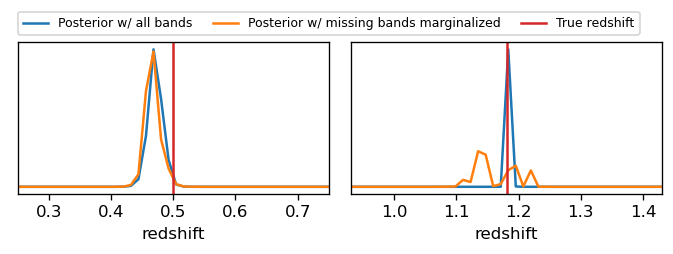

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(5.5, 2), dpi=120, constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(grid, pdfs[i], label="Posterior w/ all bands")
    ax.plot(grid, pdfs2[i], label="Posterior w/ missing bands marginalized")
    
    ztrue = samples["redshift"][i]
    ax.axvline(ztrue, c="C3", label="True redshift")
    ax.set(
        xlabel="redshift", 
        xlim=(ztrue - 0.25, ztrue + 0.25), 
        yticks=[]
    )
    
axes[0].legend(
    bbox_to_anchor=(0, 1.05, 2, 0.2), 
    loc="lower left",
    mode="expand", 
    borderaxespad=0, 
    ncol=3,
    fontsize=7.5,
)

plt.show()

You can see that marginalizing over the bands (aka throwing out information), degrades the posteriors.

Warning that marginalizing over fine grids quickly gets very computationally expensive, especially when you have rows in your data frame that are missing multiple values.